In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_porous_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_porous_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)

(1100, 2, 80, 250)
[[[-1.71246286e-03 -2.25267652e-03 -3.00801359e-03 ...  2.33484461e-05
    3.98615375e-05  4.50469670e-05]
  [-1.76043040e-03 -2.30890256e-03 -3.07564950e-03 ...  2.19718204e-05
    3.31254414e-05  3.43460706e-05]
  [-1.78716495e-03 -2.33660522e-03 -3.10492842e-03 ...  2.18894274e-05
    2.23959360e-05  2.59347871e-05]
  ...
  [ 6.69868405e-06  3.40749975e-05  5.91575081e-05 ... -1.46767981e-02
   -1.96633749e-02  9.41899139e-04]
  [-1.00837409e-04 -1.42680568e-04 -2.04633834e-04 ...  2.43966468e-02
    2.04123668e-02 -6.24794047e-04]
  [-3.38158803e-04 -5.13372943e-04 -6.11619325e-04 ... -2.12734379e-02
   -4.06960025e-05  2.26237476e-02]]

 [[-7.82928109e-05 -9.45986249e-05 -1.22269164e-04 ... -1.14489536e-04
   -7.25080172e-05 -3.63446161e-05]
  [-5.72059362e-05 -7.33694324e-05 -7.91403581e-05 ... -1.31733381e-04
   -1.17355507e-04 -7.20488461e-05]
  [-2.92610639e-05 -2.93526246e-05 -3.29154573e-05 ... -1.71276130e-04
   -1.93684929e-04 -1.79377967e-05]
  ...
  [ 

In [5]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [6]:
frac_params = pd.read_csv('frac_params_porous.csv')
frac_params['dn'] *= 2.6
frac_params['e'] *= 2.2
frac_params['aspect_ratio'] *= 197.7
frac_params = np.array(frac_params[['dn','dt','e','aspect_ratio']])

In [7]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [8]:
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        #self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0, stride=2)
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(10*15*n3,50)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=80)
        self.fc2 = torch.nn.Linear(50,20)
        self.ac2_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,4) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
            
        x = self.out(x)
        
        return x

In [9]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(4,6,2)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [10]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.008881985 
	Test Loss:	 0.019180018
epoch # 2 :
	Train Loss:	 0.0021143705 
	Test Loss:	 0.016671773
epoch # 3 :
	Train Loss:	 0.0013572471 
	Test Loss:	 0.011125407
epoch # 4 :
	Train Loss:	 0.0009509231 
	Test Loss:	 0.006925457
epoch # 5 :
	Train Loss:	 0.00081465876 
	Test Loss:	 0.003969812
epoch # 6 :
	Train Loss:	 0.00075637404 
	Test Loss:	 0.0014800717
epoch # 7 :
	Train Loss:	 0.0007333201 
	Test Loss:	 0.0009216792
epoch # 8 :
	Train Loss:	 0.00071071065 
	Test Loss:	 0.00073740963
epoch # 9 :
	Train Loss:	 0.00070177286 
	Test Loss:	 0.0007329424
epoch # 10 :
	Train Loss:	 0.00069433206 
	Test Loss:	 0.000680466
epoch # 11 :
	Train Loss:	 0.00068152003 
	Test Loss:	 0.0006724391
epoch # 12 :
	Train Loss:	 0.0006692643 
	Test Loss:	 0.0006715752
epoch # 13 :
	Train Loss:	 0.00067013624 
	Test Loss:	 0.0006566743
epoch # 14 :
	Train Loss:	 0.0006651313 
	Test Loss:	 0.0006604886
epoch # 15 :
	Train Loss:	 0.0006629792 
	Test Loss:	 0.00073357444
ep

epoch # 122 :
	Train Loss:	 0.00024863178 
	Test Loss:	 0.00023916802
epoch # 123 :
	Train Loss:	 0.00024251039 
	Test Loss:	 0.00021361328
epoch # 124 :
	Train Loss:	 0.0002572813 
	Test Loss:	 0.00027729903
epoch # 125 :
	Train Loss:	 0.00026443286 
	Test Loss:	 0.00028166492
epoch # 126 :
	Train Loss:	 0.0002458913 
	Test Loss:	 0.00020848136
epoch # 127 :
	Train Loss:	 0.0002338605 
	Test Loss:	 0.00030515317
epoch # 128 :
	Train Loss:	 0.00026598995 
	Test Loss:	 0.00024150552
epoch # 129 :
	Train Loss:	 0.0002745029 
	Test Loss:	 0.00028625352
epoch # 130 :
	Train Loss:	 0.00032444863 
	Test Loss:	 0.00030862793
epoch # 131 :
	Train Loss:	 0.00029359446 
	Test Loss:	 0.00024837055
epoch # 132 :
	Train Loss:	 0.0002739155 
	Test Loss:	 0.0003887336
epoch # 133 :
	Train Loss:	 0.00028353193 
	Test Loss:	 0.00021306559
epoch # 134 :
	Train Loss:	 0.0002470284 
	Test Loss:	 0.00022348562
epoch # 135 :
	Train Loss:	 0.00022654221 
	Test Loss:	 0.00021497103
epoch # 136 :
	Train Loss:	

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

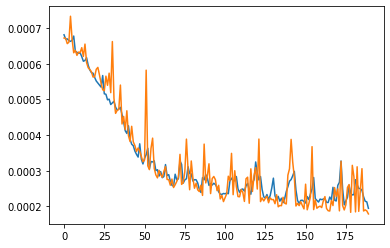

In [12]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

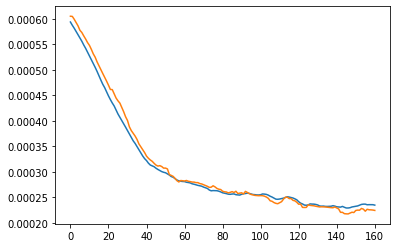

In [13]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [14]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\nReal value\nDifference\n')

sum_dn1_sq = 0.0
sum_dt1_sq = 0.0
sum_dn1 = 0.0
sum_dt1 = 0.0
sum_dn1_real = 0.0
sum_dt1_real = 0.0
sum_e1 = 0.0
sum_e1_sq = 0.0
sum_e1_real = 0.0
sum_asp = 0.0
sum_asp_sq = 0.0
sum_asp_real = 0.0
"""
frac_params['dn'] *= 2.6
frac_params['e'] *= 2.2
frac_params['aspect_ratio'] *= 197.7
[['dn','dt','e','aspect_ratio']]
"""

for i in range(300):
    # dn
    pred[i][0] /= 2.6
    y_val[i][0] /= 2.6
    
    # e
    pred[i][2] /= 2.2
    y_val[i][2] /= 2.2
    
    # aspect_ratio
    pred[i][3] /= 197.7
    y_val[i][3] /= 197.7
    
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\n',y_val[i],'\n',abs(pred[i]-y_val[i]),'\n')
    
    sum_dn1_sq += dif[0]**2
    sum_dt1_sq += dif[1]**2
    sum_e1_sq += dif[2]**2
    sum_asp_sq += dif[3]**2
    sum_dn1 += dif[0]
    sum_dt1 += dif[1]
    sum_e1 += dif[2]
    sum_asp += dif[3]
    
    sum_dn1_real += y_val[i][0]
    sum_dt1_real += y_val[i][1]
    sum_e1_real += y_val[i][2]
    sum_asp_real += y_val[i][3]
    
mean_dn1 = sum_dn1/300
mean_dt1 = sum_dt1/300
mean_e1 = sum_e1/300
mean_asp = sum_asp/300
mean_dn1_sq = sum_dn1_sq/300
mean_dt1_sq = sum_dt1_sq/300
mean_e1_sq = sum_e1_sq/300
mean_asp_sq = sum_asp_sq/300
relative_dn1 = sum_dn1/sum_dn1_real
relative_dt1 = sum_dt1/sum_dt1_real
relative_e1 = sum_e1/sum_e1_real
relative_asp = sum_asp/sum_asp_real


Predicted
Real value
Difference

[0.05091728 0.18294661 0.08207565 0.00051298] 
 [0.05141804 0.18491012 0.08303621 0.00047396] 
 [5.0076097e-04 1.9635111e-03 9.6055865e-04 3.9025705e-05] 

[0.0517386  0.17783779 0.08032066 0.00054937] 
 [0.05214043 0.17954162 0.08062541 0.00055435] 
 [4.0183216e-04 1.7038286e-03 3.0475110e-04 4.9886876e-06] 

[0.05621656 0.16893262 0.07808867 0.00095881] 
 [0.05688561 0.1699612  0.0763232  0.00099713] 
 [6.6905469e-04 1.0285825e-03 1.7654747e-03 3.8316008e-05] 

[0.04939799 0.194595   0.08693928 0.00033791] 
 [0.05005909 0.19314626 0.08673474 0.0003451 ] 
 [6.6110119e-04 1.4487356e-03 2.0454079e-04 7.1949326e-06] 

[0.04809161 0.11105172 0.05126076 0.00066477] 
 [0.04720369 0.11358529 0.05100689 0.00063496] 
 [8.8791922e-04 2.5335699e-03 2.5386736e-04 2.9814313e-05] 

[0.05578395 0.1789133  0.08114573 0.00090422] 
 [0.05675654 0.18038249 0.08100301 0.00089798] 
 [9.7259879e-04 1.4691949e-03 1.4272332e-04 6.2342733e-06] 

[0.05356567 0.14206278 0.065487

 [0.04304156 0.07993206 0.03589449 0.00064329] 
 [8.8126957e-04 1.4709756e-03 4.1894615e-04 1.7770217e-05] 

[0.04187261 0.09044486 0.04194347 0.00030914] 
 [0.04177962 0.09128354 0.04099202 0.00015219] 
 [9.2983246e-05 8.3868206e-04 9.5145404e-04 1.5695150e-04] 

[0.05261835 0.21134153 0.09776711 0.0003538 ] 
 [0.05118394 0.21678373 0.09734944 0.00034217] 
 [1.4344081e-03 5.4422021e-03 4.1767210e-04 1.1628959e-05] 

[0.05582962 0.19711167 0.0893063  0.00074519] 
 [0.05609603 0.19776314 0.08880801 0.00073376] 
 [2.6641041e-04 6.5147877e-04 4.9829483e-04 1.1427735e-05] 

[0.05337897 0.17601442 0.08025348 0.0006723 ] 
 [0.05377895 0.17812203 0.07998792 0.00068695] 
 [3.9997697e-04 2.1076053e-03 2.6556104e-04 1.4648831e-05] 

[0.05310249 0.15928835 0.07186148 0.00073666] 
 [0.05237869 0.15962999 0.07168384 0.00070533] 
 [7.2380155e-04 3.4163892e-04 1.7763674e-04 3.1330273e-05] 

[0.04486105 0.11257982 0.05226353 0.00032622] 
 [0.04487441 0.11467475 0.05149613 0.0003189 ] 
 [1.3366342e-05 

In [15]:
print('Dn mean: ', mean_dn1)
print('Dt mean: ', mean_dt1)
print('e mean: ', mean_e1)
print('aspect ratio mean: ', mean_asp)

print('Dn MSE: ', math.sqrt(mean_dn1_sq))
print('Dt MSE: ', math.sqrt(mean_dt1_sq))
print('e MSE: ', math.sqrt(mean_e1_sq))
print('aspect ratio MSE: ', math.sqrt(mean_asp_sq))

print('Dn Relative: ', relative_dn1)
print('Dt Relative: ', relative_dt1)
print('e Relative: ', relative_e1)
print('aspect ratio Relative: ', relative_asp)

Dn mean:  0.000732614939721922
Dt mean:  0.001620162622227023
e mean:  0.0004762296859795849
aspect ratio mean:  8.363924348183597e-05
Dn MSE:  0.000922018038300014
Dt MSE:  0.0019631220986011675
e MSE:  0.0005870761081519726
aspect ratio MSE:  0.00013410901985019463
Dn Relative:  0.016508022624474806
Dt Relative:  0.013965025568062695
e Relative:  0.009140980854216909
aspect ratio Relative:  0.14248825760826103


In [24]:
from math import pi
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
Ro = 2550
g = (Vs**2)/(Vp**2)
mu = Ro*(Vs**2)
lambd = Ro*(Vp**2)-2*mu
k_1 = 1.25*(10**9)
phi_p = 1/1000 # 0.1%
A_p = 3/(4*g) 
A_c = 4/9 * (3-4*g)/(g*(1-g))
"""
[['dn','dt','e','aspect_ratio']]
"""
print('e (crack density)\taspect ratio\tDn formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    asp_pred = pred[i][3]
    phi_c = 4*pi*e_pred/3 * asp_pred
    Dcp = 1/( 1 - k_1/(lambd + 2*mu/3) + k_1/((lambd + 2*mu/3)*(phi_c + phi_p))*(A_p*phi_p + A_c*e_pred) )
    formula = 4*e_pred/(3*g*(1-g)) * (1 - k_1/(lambd + 2*mu/3)) * Dcp
    dn_pred = pred[i][0]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

e (crack density)	aspect ratio	Dn formula	Predicted value	Difference
0.08207565 	 0.05181163586303189 	 0.05091728 	 0.0008943568877835539
0.08032066 	 0.052024743791404614 	 0.051738597 	 0.0002861463387640803
0.07808867 	 0.05684999196413829 	 0.056216557 	 0.0006334353852637045
0.08693928 	 0.049976641429727846 	 0.04939799 	 0.0005786513221915299
0.05126076 	 0.04749171185229594 	 0.048091605 	 0.0005998934533757508
0.08114573 	 0.056871074119572 	 0.055783946 	 0.001087128052477196
0.06548781 	 0.05333545733613762 	 0.053565674 	 0.0002302161939641556
0.02467227 	 0.03846773142316429 	 0.038854808 	 0.00038707619211585803
0.023456253 	 0.03767552861875663 	 0.03784867 	 0.00017314141684403317
0.099363245 	 0.04882165938066511 	 0.05095702 	 0.0021353609914872215
0.003354448 	 0.014038717028305914 	 0.012361682 	 0.0016770350081781408
0.07112071 	 0.0488441190197898 	 0.049062118 	 0.00021799891443718966
0.08052205 	 0.055345354194910754 	 0.054839224 	 0.0005061305716349968
0.0141

0.059796844 	 0.050636062999350445 	 0.05005379 	 0.0005822727876728939
0.054052047 	 0.044212700146374406 	 0.04386911 	 0.0003435884594294447
0.019174702 	 0.03535894354240951 	 0.036769442 	 0.0014104987178558404
0.07642451 	 0.05502051951573093 	 0.0546992 	 0.0003213183789034582
0.059040446 	 0.05026072562542084 	 0.04991818 	 0.00034254715647819706
0.05819169 	 0.04525274122139306 	 0.045645677 	 0.0003929353318562964
0.059853766 	 0.04492892170721918 	 0.045585707 	 0.0006567851228055366
0.094803095 	 0.05103988817400808 	 0.05118464 	 0.0001447511606705726
0.058710046 	 0.05003659527771915 	 0.04979208 	 0.00024451416008914456
0.05014728 	 0.0487544817516751 	 0.04955921 	 0.0008047277441077527
0.040147994 	 0.043393589278148945 	 0.043201424 	 0.0001921650966876104
0.035152406 	 0.0428575190852393 	 0.043760784 	 0.0009032648851166891
0.066507496 	 0.04791389487435447 	 0.04819807 	 0.0002841755027569656
0.09934793 	 0.058349815542255615 	 0.05767225 	 0.0006775645263540492


In [25]:
print('Mean difference between predicted value and formula for Dn: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn: ', sum_dif/abs(sum_dn1_real))

Mean difference between predicted value and formula for Dn:  0.000731599526184749
Relative difference between predicted value and formula for Dn:  0.016485142297121374


In [28]:
print('e (crack density)\tDt formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = 16*e_pred/(3*(3-2*g))
    dt_pred = pred[i][1]
    dif = abs(dt_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dt_pred,'\t',dif)

e (crack density)	Dt formula	Predicted value	Difference
0.08207565 	 0.1827711020398654 	 0.18294661 	 0.00017550543064698276
0.08032066 	 0.17886297853771146 	 0.17783779 	 0.0010251894790261618
0.07808867 	 0.17389265629842035 	 0.16893262 	 0.004960039587757509
0.08693928 	 0.1936017429986262 	 0.194595 	 0.0009932511887288387
0.05126076 	 0.11415060975108614 	 0.111051716 	 0.003098893840651415
0.08114573 	 0.1807003114152137 	 0.1789133 	 0.001787016146201248
0.06548781 	 0.14583228276517546 	 0.14206278 	 0.0037694995239034856
0.02467227 	 0.054941728203016266 	 0.05234702 	 0.0025947088882503355
0.023456253 	 0.05223382738786351 	 0.04887317 	 0.0033606561775745072
0.099363245 	 0.2212681866554892 	 0.21928214 	 0.0019860512880957026
0.003354448 	 0.0074698909256469895 	 0.0055893213 	 0.0018805696699630906
0.07112071 	 0.15837597034005713 	 0.16087392 	 0.0024979493853609647
0.08052205 	 0.17931146097415507 	 0.17620784 	 0.0031036205314975973
0.014153648 	 0.03151821443083888 

0.057669714 	 0.1284224670134075 	 0.12861845 	 0.00019598195929451667
0.09244892 	 0.20587094226643368 	 0.20605597 	 0.000185026733428989
0.067989714 	 0.15140367864981738 	 0.14627498 	 0.005128694766913328
0.06434 	 0.14327627631965906 	 0.14148003 	 0.0017962476903560787
0.07157079 	 0.1593782408999003 	 0.1632488 	 0.0038705662919484574
0.04474437 	 0.09963951263480826 	 0.09547719 	 0.004162319040829379
0.08005596 	 0.17827353547161953 	 0.1771652 	 0.0011083401257409309
0.087891735 	 0.1957227226421911 	 0.19480124 	 0.0009214814827520068
0.06905915 	 0.1537851600408056 	 0.15069348 	 0.003091683840701853
0.047098678 	 0.104882232663361 	 0.10037521 	 0.0045070199343837936
0.014622756 	 0.032562853233135645 	 0.03127928 	 0.0012835724513897348
0.05387952 	 0.11998223362486646 	 0.118728034 	 0.0012541994265823087
0.013369718 	 0.02977250969567561 	 0.028080344 	 0.0016921654955413326
0.0900996 	 0.2006393384833923 	 0.19723028 	 0.0034090590377441055
0.09347527 	 0.208156475526

In [29]:
print('Mean difference between predicted value and formula for Dt: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dt: ', sum_dif/abs(sum_dt1_real))

Mean difference between predicted value and formula for Dt:  0.0023527466743921755
Relative difference between predicted value and formula for Dt:  0.02027954910964319
